In [11]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
OP_FIL_DIR = "output"

In [13]:
def load_data(file_name):
    with open(f'{OP_FIL_DIR}/{file_name}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data

In [14]:
def load_df(file_name):
    data = load_data(file_name)
    df = pd.DataFrame(data)
    return df

def avg_df(df):
    return df.groupby(['input_file', 'approach']).mean().reset_index()

def all_opers(file_name):
    df = load_df(file_name)
    df = avg_df(df)
    return df

In [15]:
seq_df = all_opers("sequential")

In [16]:
h1_df = all_opers("hashing_per_tree")
h1_df['speedup'] = seq_df['hashTime'].values / h1_df['hashTime'].values

In [17]:
h2_df = load_df("hashing_per_workers")
h2_df = h2_df.groupby(['input_file', 'approach', 'hashWorkers']).mean().reset_index()

In [18]:
h2_idx = h2_df.groupby(['input_file', 'approach'])['hashTime'].idxmin()
h2_df_max = h2_df.loc[h2_idx].reset_index(drop=True)
h2_df_max['speedup'] = seq_df['hashTime'].values / h2_df_max['hashTime'].values

In [19]:
speedup_h1_h2 = pd.concat([h2_df_max, h1_df], ignore_index=True)
speedup_h1_h2.drop(columns=['hashTime', 'dataWorkers', 'compWorkers', 'useBuffer', 'useChannels', 'trial_id'], inplace=True)

In [20]:
def plot_hash_performance():
    files = seq_df['input_file'].unique()
    x = np.arange(len(files))

    bar_width = 0.25
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar(x, seq_df['hashTime'], bar_width, label='sequential')
    ax.bar(x + bar_width, h1_df['hashTime'], bar_width, label='hashes_per_tree')
    ax.bar(x + 2 * bar_width, h2_df_max['hashTime'], bar_width, label='hashes_per_workers')

    ax.set_xlabel('Input Files')
    ax.set_ylabel('Hash Time (seconds)')
    ax.set_title('Hash Time Comparison Across Input Files')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(files)
    ax.legend()

    plt.show()

def plot_graph(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.barplot(x='input_file', y=column_name, hue='approach', data=df)
    plt.title(f'{column_name} Comparison Across Files and Algorithms', fontsize=16)
    plt.xlabel('file_name', fontsize=12)
    plt.ylabel(f'{column_name}', fontsize=12)

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_comp_performance(seq_df, c1_df, c2_df):
    files = c1_df['input_file'].unique()
    x = np.arange(len(files))

    bar_width = 0.25
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar(x, seq_df['compareTreeTime'], bar_width, label='sequential')
    ax.bar(x + bar_width, c1_df['compareTreeTime'], bar_width, label='buffered')
    ax.bar(x + 2 * bar_width, c2_df['compareTreeTime'], bar_width, label='unbuffered')


    ax.set_xlabel('Input Files')
    ax.set_ylabel('compare Tree Time (seconds)')
    ax.set_title('compare Tree Time Comparison Across Input Files')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(files)
    ax.legend()

    plt.show()

### GPU Hardware Details
1. Graphics: Nvidia RTX 4090 24Gb
2. Cores: 16384
3. Clock Speed: 2235Mhz
4. Memory Bandwidth (GB/sec): 1008
5. TDP: 450W


### CPU Hardware Details
1. CPU: 12th Gen Intel® Core™ i9-12900K
2. Cores: 16 (8 performance-cores(5.10 GHz) and 8 efficient-cores(3.90 GHz))
3. Threads: 24
4. Cache: 30MB
5. L2 Cache: 14MB

### RAM: 64GB
### OS: Ubuntu 24.04.1 LTS

### Amount of time spend on lab: ~50hrs



## Experiment setting:
1. The python script `run_tests.py` generates the data for the analysis for fine and coarse text files.
2. I have implemented the optional approaches as well.
3. I have broadly classified the approaches into following categories:
    * sequential
    * channel - when hashWorkers = i, dataWorkers = 1
    * single_mutexes - when hashWorkers = i, dataWorkers = i
    * multiple_mutexes - when hashWorkers = i, dataWorkers = j
    * multiple_mutexes_channel - when hashWorkers = i, dataWorkers = j
    * buffered
    * unbuffered
4. For each of the above approaches, I ran *10 trials* of each approach with hashWorkers = [2,4,8,16,N] and data/comp workers = [1,2,3,8,16].
5. The results are then averaged - all the graphs presented below are the avg of 10 trails to ensure consistency in output.


## 1. Sequential Implementation
1. I have started by implementing a sequential version of the code. Below are the results for the sequential version on my machine.

In [21]:
seq_df

,input_file,approach,hashTime,hashGroupTime,compareTreeTime,hashWorkers,dataWorkers,compWorkers,useBuffer,useChannels,trial_id
0,coarse,sequential,0.032922,0.032957,1.017619,1.0,1.0,1.0,0.0,0.0,4.5
1,fine,sequential,0.032482,0.032514,2.938572,1.0,1.0,1.0,0.0,0.0,4.5


## 2. Parallelize Hash Operations
1. hashes_per_tree approach: In this version, I have spin up a go routine for every tree to compute the hash.
2. hashes_per_workers approach: In this version, I have created hash-worker number of go routines to compute the hashes.

The below graph shows the performance of each of the above implementations along with sequential version.

#### 2.1 Speed Up
1. As can be seen in the below graph, the hashing_per_workers appear to outperform sequential and hashing_per_tree for the dataset - fine.txt where as hashing_per_tree is slightly better than the other two for the dataset coarse.txt
2. In terms of speed up, hashing_per_workers is almost ~2.5 times faster than sequential version for the dataset coarse.txt and 1.3 times for fine.txt.
3. Where hashing_per_tree is 2.65 times faster than sequential version for the dataset coarse.txt and 1.3 times for fine.txt.
4. Given that the speed-up is not off by a significant margin, I will follow the hashing_per_workers approach for the rest of the experiments.
5. While the number of hashWorkers is not the same where hashTime is minimum for the coarse.txt and fine.txt, I will use hashWorkers = 16 for coarse.txt and hashWorkers = 4 for fine.txt for the rest of the analysis as both the datasets appear to have done consistently better at these numbers.

##### TLDR; Faster Implementation is Hashing using Number of Hash provided, at hashWorkers = 16 for coarse.txt, hashWorkers=4 for fine.txt

#### 2.2 Can Go manage goroutines well enough that you don't have to worry about how many threads to spawn anymore?
1. yes, Go manages goroutines well enough for me not to worry about the number of threads being spawned as even for 100k go routines, I have seen more or less similar times when compared with sequential implementation. That shows that the overhead of creating more goroutines is very less in go as compared with spawning more threads in java or C++ where due to context switching, the time would be much worse than sequential implementation. We have established the overhead of context switching in the past assignment in C++, and from my professional experience, java makes it even worse. But clearly, go wins in this aspect.

In [22]:
fine_hash_worker = 4
coarse_hash_worker = 16
speedup_h1_h2

,input_file,approach,hashWorkers,speedup
0,coarse,hashing_per_workers,16.0,2.491592
1,fine,hashing_per_workers,4.0,1.288117
2,coarse,hashing_per_tree,2.0,2.640702
3,fine,hashing_per_tree,2.0,0.955446


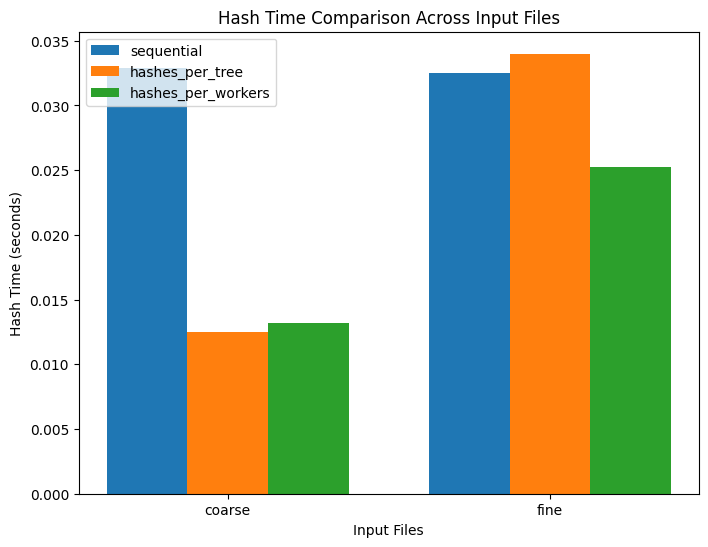

In [23]:
plot_hash_performance()

In [24]:
h3_df = load_df("hashgroups_channel")
h3_df = h3_df.groupby(['input_file', 'approach', 'hashWorkers', 'dataWorkers']).mean().reset_index()
h4_df = load_df("hashgroups_mutexes")
h4_df = h4_df.groupby(['input_file', 'approach', 'hashWorkers', 'dataWorkers']).mean().reset_index()
df_combined = pd.concat([h3_df, h4_df], ignore_index=True)
filtered_df = df_combined[((df_combined['input_file'] == 'coarse') & (df_combined['hashWorkers'] == coarse_hash_worker)) |
                 ((df_combined['input_file'] == 'fine') & (df_combined['hashWorkers'] == fine_hash_worker))]
com_idx = filtered_df.groupby(['input_file', 'approach'])['hashGroupTime'].idxmin()
filtered_df = filtered_df.loc[com_idx].reset_index(drop=True)
filtered_df = pd.concat([filtered_df, seq_df], ignore_index=True)
filtered_df

,input_file,approach,hashWorkers,dataWorkers,hashTime,hashGroupTime,compWorkers,useBuffer,useChannels,trial_id,compareTreeTime
0,coarse,channel,16.0,1.0,0.011716,0.011794,0.0,0.0,0.0,4.5,NaN
1,coarse,multiple_mutexes,16.0,2.0,0.012457,0.012635,0.0,0.0,0.0,4.5,NaN
2,coarse,multiple_mutexes_channel,16.0,4.0,0.012682,0.012791,0.0,0.0,1.0,4.5,NaN
3,coarse,single_mutexes,16.0,16.0,0.012930,0.013037,0.0,0.0,1.0,4.5,NaN
4,fine,channel,4.0,1.0,0.030772,0.031441,0.0,0.0,1.0,4.5,NaN
5,fine,multiple_mutexes,4.0,2.0,0.029629,0.029711,0.0,0.0,0.0,4.5,NaN
6,fine,multiple_mutexes_channel,4.0,2.0,0.033764,0.034335,0.0,0.0,1.0,4.5,NaN
7,fine,single_mutexes,4.0,4.0,0.028629,0.028708,0.0,0.0,0.0,4.5,NaN
8,coarse,sequential,1.0,1.0,0.032922,0.032957,1.0,0.0,0.0,4.5,1.017619
9,fine,sequential,1.0,1.0,0.032482,0.032514,1.0,0.0,0.0,4.5,2.938572


#### 2.3 Identifying duplicates and forming HashGroups
1. At first, I have implemented the below 2 approaches:
2. Using a Channel approach - Uses a channel with 1 dataWorker, no locks involved
3. Using a single lock (single_mutexes) approach - Uses a single lock to access the Data structure

As can be seen from the below graph, the results are different for both the datasets.
#### 2.3.1 Which approach has more overhead? 
1. The implementation with channel has more overhead for fine dataset where as using single locks has more overhead in coarse dataset.
3. In the coarse dataset, since each tree has more nodes, a single goroutine processes more data (nodes) per tree, which results in more values being sent to the channel at a faster rate. This higher rate of data entry into the channel can increase throughput, potentially saturating the channel and reducing its overhead compared to the fine dataset, where trees are smaller and each goroutine processes fewer nodes.
4. In the fine dataset, the slower rate of data entering the channel (because each goroutine sends fewer values) makes the relative overhead of managing the channel more pronounced. The channel has to synchronize frequently for smaller amounts of data, which leads to increased overhead in this case.

#### 2.3.2 How much faster are they compared to a single thread? 
1. The implementation with single mutex is faster for fine dataset where as using single channel is faster in coarse dataset. But relatively speaking, both the implementations are faster than sequential version as shown in the graph below.
2. The reasoning is the same as what I have stated in 2.3.1.

#### 2.3.3 Which approach do you find simpler?
1. I find the approach to use the channel simpler as it allowed me to split the hashing and collecting the hashes into 2 different methods. There could be more optimizations that I could employ to make it faster while using channels.

I have then implemented two more approaches as stated below.
1. using data-workers number of locks (multiple_mutexes)
2. using data-workers number of locks with a channel listener (multiple_mutexes_channel)

#### 2.3.4 Was access to the shared data structure a bottleneck before? 
1. Looking at the results, below, both then implementations did not outperform the single mutex approach for fine dataset and channel approach for the coarse dataset.
2. If access to the shared data structure (whether protected by a lock or using channels) were a significant bottleneck, we would expect to see performance improvements with methods that reduce contention. Since these methods did not show better performance, it is reasonable to conclude that access to the data structure was not the main limiting factor in previous iterations.

#### 2.3.5 How do channels and locks compare now that there is more parallelism?
1. Channels: With channels, maybe if the data structure itself was sharded, the performance would have been much better where contention can be totally avoided.
2. Locks: With more locks gives increased parallelism, so, I was expecting to see an increase in performance for fine dataset but in practice it degraded a little as compared to using single mutex for fine dataset. 

For 3rd part, I will use the single_mutexes implementation as it is faster in fine dataset and is only slightly differs from channel implementation for coarse.

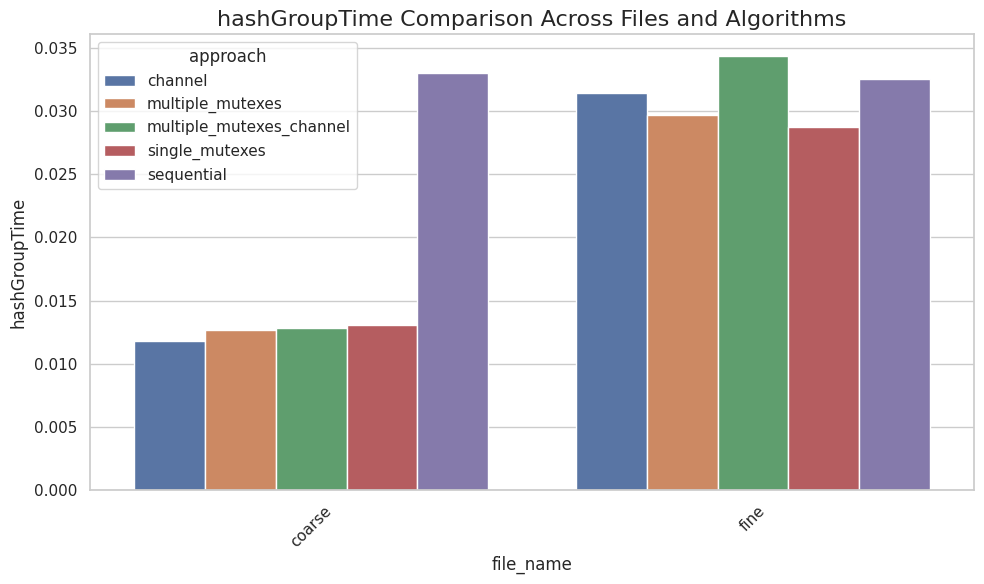

In [25]:
plot_graph(filtered_df, 'hashGroupTime')

In [26]:
c1_df = load_df('comp_groups_buffer_mutexes')
c1_df = c1_df.groupby(['input_file', 'approach', 'hashWorkers', 'dataWorkers', 'compWorkers']).mean().reset_index()
c1_df = c1_df[(c1_df['compWorkers'] != 1) & (c1_df['approach'] == 'single_mutexes')]
c1_idx = c1_df.groupby(['input_file', 'approach'])['compareTreeTime'].idxmin()
c1_df = c1_df.loc[c1_idx].reset_index(drop=True)

c2_df = load_df('comp_groups_unbuffer_mutexes')
c2_df = c2_df.groupby(['input_file', 'approach', 'hashWorkers', 'dataWorkers', 'compWorkers']).mean().reset_index()
c2_df = c2_df[(c2_df['approach'] == 'single_mutexes')]
c2_idx = c2_df.groupby(['input_file', 'approach'])['compareTreeTime'].idxmin()
c2_df = c2_df.loc[c2_idx].reset_index(drop=True)

#### 3 Parallelize Tree Comparisons
The results for this experiment fall in line with my theoretical understanding of Go and it's benefits !!

#### How do the performance and complexity of both approaches compare with each other? 
1. Unbuffered:
    * Complexity: The complexity is low in terms of implementation since we simply spawn a goroutine for each comparison and let Go’s runtime handle the scheduling and execution.
    * Performance: This approach is faster because all tree comparisons can happen concurrently, with each comparison running independently in its own goroutine. There is no restriction on the number of goroutines running in parallel, maximizing the potential concurrency.
2. Buffered:
    * Complexity: This approach introduces additional complexity since we need to manage the bounded buffer and control the flow of comparisons to ensure that no more than comp_workers comparisons are running at once and ensuring that no more than 2 go routines are modifying the buffer.
    * Performance: This approach tends to be slower compared to spawning a goroutine for each comparison because the bounded buffer restricts the number of concurrent comparisons to the size of comp_workers. This limits the overall parallelism.
#### How do they scale compared to a single thread? 
1. Unbuffered: The unbuffered approach, where a goroutine is spawned for each comparison, scales very well compared to sequential execution. Since each comparison runs concurrently, the total time is significantly reduced in comparison to running the comparisons one by one in a single thread. The same can clearly be seen in the below graph. The unbuffered approach scales well as long as the system can handle the number of goroutines being spawned - which did not appear to be the problem even when we spawn 100k go routines.
2. Buffered: The buffered approach scales poorly compared to both the unbuffered parallel approach and sequential execution when the buffer size is too small. If comp_workers is too restrictive, the performance can degrade, especially if the system has enough resources to handle more concurrent work.

#### Is the additional complexity of managing a thread pool worthwhile?
1. From this experiment, I would say not as much as go is doing a pretty decent job at managing the underlying resources. 
2. But when resources are limited, be it CPU or Memory, having a thread pool would help in achieving consistent throughput.

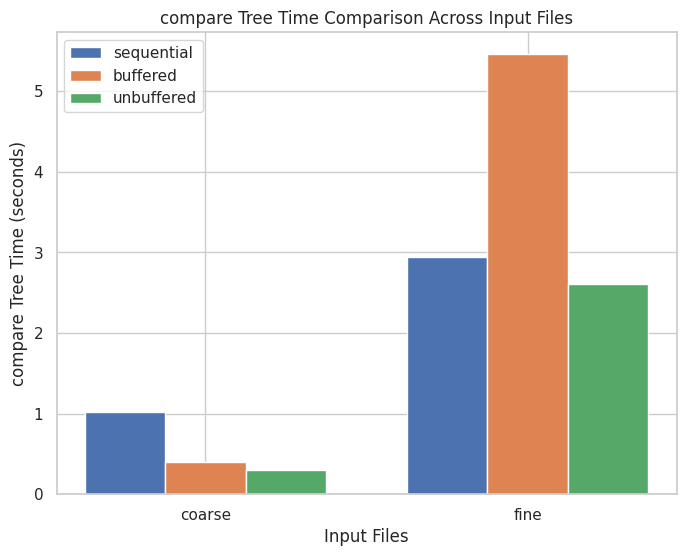

In [27]:
plot_comp_performance(seq_df, c1_df, c2_df)